In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
scene_paths = glob('../Dataset_CNN/*/')

# Fulfill data
X_ = []
y_ = []
Xtest_ = []
ytest_ = []

print('Loading training data')
for scene in scene_paths[0:-6]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path[0:1]:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
        
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            X_.append(img)
            y_.append(NLF*100)

print('Loading testing data')
for scene in scene_paths[-6:-1]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path[0:1]:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
            
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            Xtest_.append(img)
            ytest_.append(NLF*100)
            

Loading training data
../Dataset_CNN/Scene_24/
../Dataset_CNN/Scene_23/
../Dataset_CNN/Scene_15/
../Dataset_CNN/Scene_12/
../Dataset_CNN/Scene_13/
../Dataset_CNN/Scene_14/
../Dataset_CNN/Scene_22/
../Dataset_CNN/Scene_25/
../Dataset_CNN/Scene_07/
../Dataset_CNN/Scene_36/
../Dataset_CNN/Scene_09/
../Dataset_CNN/Scene_31/
../Dataset_CNN/Scene_30/
../Dataset_CNN/Scene_08/
../Dataset_CNN/Scene_06/
../Dataset_CNN/Scene_20/
../Dataset_CNN/Scene_18/
../Dataset_CNN/Scene_27/
../Dataset_CNN/Scene_11/
../Dataset_CNN/Scene_29/
../Dataset_CNN/Scene_16/
../Dataset_CNN/Scene_28/
../Dataset_CNN/Scene_17/
../Dataset_CNN/Scene_10/
../Dataset_CNN/Scene_19/
../Dataset_CNN/Scene_26/
Loading testing data
../Dataset_CNN/Scene_21/
../Dataset_CNN/Scene_32/
../Dataset_CNN/Scene_35/
../Dataset_CNN/Scene_34/
../Dataset_CNN/Scene_33/


In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)

Xtest_ = np.asarray(Xtest_)
ytest_ = np.asarray(ytest_)


In [3]:
print(np.shape(X_))
print(np.shape(y_))
print()
print(np.shape(Xtest_))
print(np.shape(ytest_))

(130, 256, 256, 3)
(130, 192)

(25, 256, 256, 3)
(25, 192)


### Crear modelo

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
from keras.layers import LeakyReLU
import keras
# First, define the vision modules
input_imgs = Input(shape=(256, 256, 3))

# Model
def get_model_column(ks_1, ks_2):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    out = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    return out

# Create independent models
model_a = Model(input_imgs, get_model_column(5, 3))
model_b = Model(input_imgs, get_model_column(7, 5))
model_c = Model(input_imgs, get_model_column(9, 7))


### Training

In [5]:
from keras import optimizers
from keras import losses

sgd = optimizers.SGD(lr=0.000001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
#model_abc.compile(optimizer= sgd, loss='mse')
#model_abc.compile(optimizer= sgd, loss=losses.kullback_leibler_divergence)


In [6]:
import matplotlib.pyplot as plt

def pred_mc_indep_net(model, ii):
    
    y_pred = np.transpose(model.predict([[X_[ii]]]))

    fig, ax = plt.subplots()
    #y_pred[y_pred < 0] = 0
    ax.plot(y_pred,'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='pred nlf')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(y_[ii],'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='test nlf')
    plt.show()
    
def train_indep_model(model, X_, y_, Xtest_, ytest_):
    # Variables for convergence checking
    converged = False

    print()
    std_thold = 0.001
    
    count = 0
    hist_loss = []
    hist_val_loss = []

    while not converged:

        print('Iteration ' + str(count+1))

        # Training the model
        history = model.fit(x=X_, y=y_, validation_data=(Xtest_, ytest_), 
                                epochs=1, shuffle=True, batch_size = 64)

        pred_mc_indep_net(model, 0)

        count += 1
        mean_samples = 6

        # Checking the convergence of the model using the standard deviation of the accuracy for some epochs
        hist_loss.extend(history.history["loss"])
        hist_val_loss.extend(history.history["val_loss"])    

        used_hist_val_loss = hist_val_loss[max(0,len(hist_val_loss)-mean_samples):len(hist_val_loss)]

        if len(used_hist_val_loss) >= mean_samples:
            mean_acc = float(sum(np.asarray(used_hist_val_loss)))/float(len(used_hist_val_loss))
            std_cutre = float(sum(np.abs(np.asarray(used_hist_val_loss)-mean_acc)))/float(len(used_hist_val_loss))

            print("STD OF " + str(len(used_hist_val_loss)) + ' SAMPLES: '),
            print(std_cutre)

            if std_cutre < std_thold or count > 2:
                converged = True

        else:
            # converged = True # Useful for testing
            print("Not enough samples to compute the STD :(")

        print('\n')
        
        return model, hist_loss, hist_val_loss


In [7]:
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________


Iteration 1
Instructions for updating:
Use tf.cast instead.
Train on 130 samples, validate on 25 samples
Epoch 1/1
130/130 [==============================] - 25s 189ms/step - loss: 4.5084 - val_loss: 4.2783


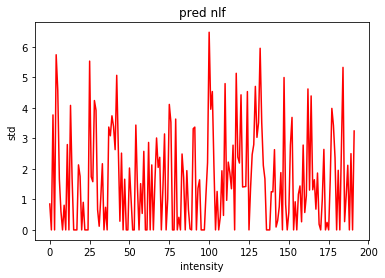

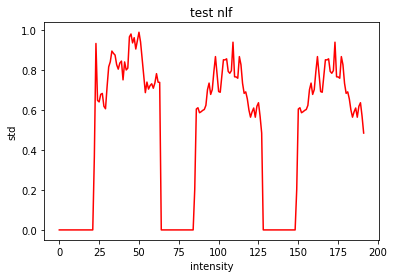

Not enough samples to compute the STD :(



Iteration 1
Train on 130 samples, validate on 25 samples
Epoch 1/1
130/130 [==============================] - 28s 213ms/step - loss: 4.3936 - val_loss: 3.6835


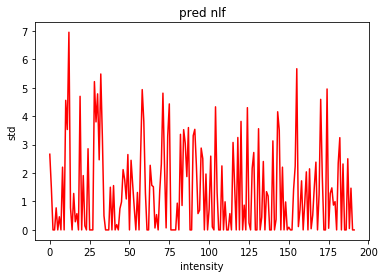

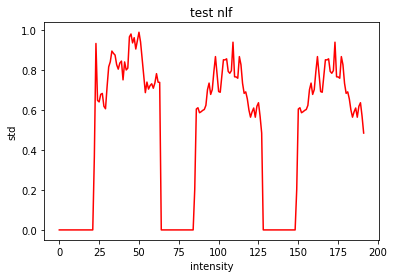

Not enough samples to compute the STD :(



Iteration 1
Train on 130 samples, validate on 25 samples
Epoch 1/1
130/130 [==============================] - 21s 159ms/step - loss: 4.5097 - val_loss: 4.3334


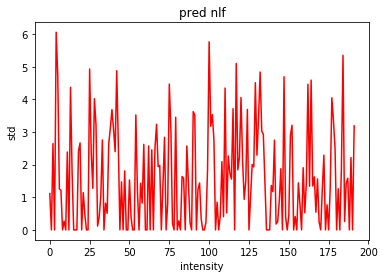

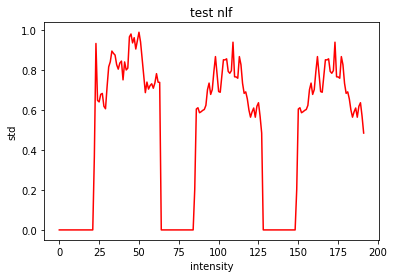

Not enough samples to compute the STD :(




In [8]:
# Train model A
model_a.compile(optimizer= sgd, loss='mse')
model_a, hist_loss_a, hist_val_loss_a = train_indep_model(model_a, X_, y_, Xtest_, ytest_)
# Train model B
model_b.compile(optimizer= sgd, loss='mse')
model_b, hist_loss_b, hist_val_loss_b = train_indep_model(model_b, X_, y_, Xtest_, ytest_)
# Train model C
model_c.compile(optimizer= sgd, loss='mse')
model_c, hist_loss_c, hist_val_loss_c = train_indep_model(model_a, X_, y_, Xtest_, ytest_)

In [12]:
model_a.layers.pop()
model_a.layers.pop()
model_b.layers.pop()
model_b.layers.pop()
model_c.layers.pop()
model_c.layers.pop()

In [13]:
model_a.summary()
model_b.summary()
model_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_13 (Batc (None, 126, 126, 64)      256       
_________________________________________________________________
activation_13 (Activation)   (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 61, 61, 64)        256       
__________

In [14]:
# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) 
input_c = Input(shape=(256, 256, 3)) 

# The vision model will be shared, weights and all
out_a = model_a(input_a)
out_b = model_b(input_b)
out_c = model_c(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=1)
merge_abc = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(concatenated)
merge_abc = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(merge_abc)
model_abc = Model([input_a, input_b, input_c], merge_abc)

In [15]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 192)          116672      input_3[0][0]                    
__________________________________________________________________________________________________
model_5 (M

In [ ]:
# Train model ABC
model_abc.compile(optimizer= sgd, loss='mse')
model_abc, hist_loss_abc, hist_val_loss_abc = train_indep_model(model_abc, [X_,X_,X_], y_, 
                                                                [Xtest_,Xtest_,Xtest_], ytest_)


Iteration 1
Train on 130 samples, validate on 25 samples
Epoch 1/1
 64/130 [=============>................] - ETA: 52s - loss: 5.9477

In [ ]:
import matplotlib.pyplot as plt
ii = 27

y_pred = np.transpose(model_abc.predict([[X_[ii]],[X_[ii]],[X_[ii]]]))

fig, ax = plt.subplots()
#y_pred[y_pred < 0] = 0
ax.plot(y_pred,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[ii],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.io


scene = 'Scene_21'
nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
NLF = mat["NLF"][0]
NLF_r = np.nan_to_num(NLF[0:256])

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y,b,a

order = 5
fs = 30    # sample rate, Hz
cutoff = 2
y,b,a = butter_lowpass_filter(NLF_r, cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

fig, ax = plt.subplots()
ax.plot(y,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf filtered')
plt.show()

fig, ax = plt.subplots()
ax.plot(NLF_r,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()